# Setup
This IPython notebook will walk through the steps of characterizing iModulons through the semi-automated tools in PyModulon. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `1_create_the_gene_table.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [142]:
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations
from pymodulon.core import IcaData
from pymodulon.plotting import *
import pymodulon.io
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_contents
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from scipy.stats import fisher_exact
import numpy as np

base_dir = '/home/chris/zuniga/iModulonMiner'

def fisher_test_sets(set1, set2, universe_size=None):
    """
    Perform Fisher's exact test on two sets
    
    Parameters:
    set1, set2: sets to compare
    universe_size: total number of possible elements (if None, uses union of both sets)
    
    Returns:
    odds_ratio, p_value
    """
    if universe_size is None:
        universe_size = len(set1.union(set2))
    
    # Create contingency table
    n11 = len(set1.intersection(set2))  # In both sets
    n10 = len(set1 - set2)              # Only in set1
    n01 = len(set2 - set1)              # Only in set2
    n00 = universe_size - n11 - n10 - n01  # In neither set
    
    contingency_table = np.array([[n11, n10],
                                [n01, n00]])
    
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

In [143]:
# Enter the location of your data here
data_dir = path.join(base_dir,'data','processed_data')

# GO and KEGG annotations are in the 'external' folder
external_data = path.join(base_dir,'data','external')

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [144]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata.tsv'),index_col=0,sep='\t')
df_metadata[['project','condition']].head()

,project,condition
Kiley_A_DZM0422_Aerobic_A,aerobicity,DZM0422_Aerobic
Kiley_A_DZM0422_Aerobic_B,aerobicity,DZM0422_Aerobic
Kiley_A_DZM0422_Aerobic_C,aerobicity,DZM0422_Aerobic
Kiley_A_DZM0422_Anaerobic_A,aerobicity,DZM0422_Anaerobic
Kiley_A_DZM0422_Anaerobic_B,aerobicity,DZM0422_Anaerobic


In [145]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [146]:
df_trn = pd.read_csv(path.join(external_data,'TRN.csv'))
df_trn.head()

,regulator,gene_id
0,ZMO0023,ZMO1_ZMO0011
1,ZMO0781,ZMO1_ZMO0011
2,ZMO1121,ZMO1_ZMO0011
3,ZMO1336,ZMO1_ZMO0011
4,ZMO1412,ZMO1_ZMO0011


The `regulator` and `gene_id` must be filled in for each row

In [147]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [148]:
drop_genes = []#'ZCP4_0001', 'ZCP4_0002', 'ZCP4_0003', 'ZCP4_0004']
A = pd.read_csv(path.join(data_dir,'A.csv'), index_col = 0)
X = pd.read_csv(path.join(data_dir,'log_tpm_norm.csv'), index_col = 0).drop(index = drop_genes)
M = pd.read_csv(path.join(data_dir,'M.csv'), index_col = 0).drop(index = drop_genes)
try:
    iM_table = pd.read_csv(path.join(data_dir, 'imodulon_table.csv'), index_col = 0)
    index_to_iM = {str(index) : row['name'] for index, row in iM_table.iterrows()}
    M = M.rename(columns = index_to_iM)
    index_to_iM = {int(index) : row['name'] for index, row in iM_table.iterrows()}
    A = A.rename(index = index_to_iM)
    iM_table = iM_table.set_index('name')

    ica_data = IcaData(M = M,
                   A = A,
                   X = X,
                   imodulon_table = iM_table,
                   gene_table = path.join(data_dir,'gene_info.csv'),
                   sample_table = path.join(data_dir,'metadata.tsv'),
                   trn = path.join(external_data,'TRN.csv'),
                   threshold_method = 'kmeans',
                   optimize_cutoff=True)
except:
    # these don't always exist, skip if so
    ica_data = IcaData(M = M,
                       A = A,
                       X = X,
                       #imodulon_table = iM_table,
                       gene_table = path.join(data_dir,'gene_info.csv'),
                       sample_table = path.join(data_dir,'metadata.tsv'),
                       trn = path.join(external_data,'TRN.csv'),
                       threshold_method = 'kmeans',
                       optimize_cutoff=True)

# hard setting some different cutoffs
#ica_data._thresholds['plasmid'] = 0.075

If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [97]:
# ica_data = IcaData(M = path.join(data_dir,'M.csv'),
#                    A = path.join(data_dir,'A.csv'),
#                    X = path.join(data_dir,'log_tpm_norm.csv'),
#                    gene_table = path.join(data_dir,'gene_info.csv'),
#                    sample_table = path.join(data_dir,'metadata.tsv'),
#                    trn = path.join(data_dir,'TRN.csv'),
#                    threshold_method = 'kmeans')

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [98]:
temp = ica_data.compute_trn_enrichment(fdr = 1)
new_vals = []
for index, row in temp.iterrows():
    regulator = row['regulator']#'ZCP4_1382'
    iModulon = row['imodulon']#'transport_1'
    reg_genes = set(ica_data.trn[ica_data.trn['regulator'] == regulator].gene_id)
    iM_genes = set(ica_data.view_imodulon(iModulon).index)
    odds_ratio, p_value = fisher_test_sets(reg_genes, iM_genes, len(ica_data.gene_table))
    new_vals.append(p_value)
temp['fisher_p_value'] = new_vals
temp.to_csv(base_dir+'/data/processed_data/DAP_seq_iModulon_overlap.csv')

In [99]:
best_vals = []
for iM, df in temp.groupby('imodulon'):
    if 'SG_' in str(iM): continue
    best_p_val = min(df['fisher_p_value'])
    best_vals.append(best_p_val)
pct = [val < 0.01 for val in best_vals].count(True) / len(best_vals)
print(str(100*pct)+'% p_val under 0.01')
print('median = ', end = '')
print(np.median(best_vals))

36.58536585365854% p_val under 0.01
median = 0.024159335840790296


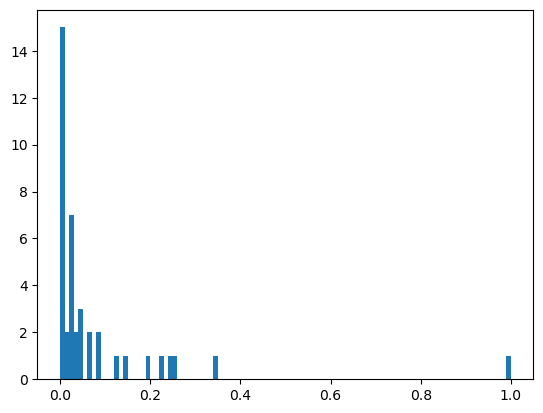

In [100]:
# histogram of these qvalues
best_vals = []
for iM, df in temp.groupby('imodulon'):
    if 'SG_' in str(iM): continue
    best_p_val = min(df['fisher_p_value'])
    best_vals.append(best_p_val)
plt.hist(best_vals, bins = 100)
plt.show()

In [101]:
temp = ica_data.compute_trn_enrichment(fdr = .01)
new_vals = []
for index, row in temp.iterrows():
    regulator = row['regulator']#'ZCP4_1382'
    iModulon = row['imodulon']#'transport_1'
    reg_genes = set(ica_data.trn[ica_data.trn['regulator'] == regulator].gene_id)
    iM_genes = set(ica_data.view_imodulon(iModulon).index)
    odds_ratio, p_value = fisher_test_sets(reg_genes, iM_genes, len(ica_data.gene_table))
    new_vals.append(p_value)
temp['fisher_p_value'] = new_vals
temp.sort_values(by = 'pvalue')

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,fisher_p_value
16,noise_2,ZMO1412,4.579289e-09,6.868934e-08,0.800000,0.049180,0.092664,12.0,244.0,15.0,1.0,4.579289e-09
2,membrane_cobalmin,ZMO1412,3.619136e-07,1.049549e-05,0.450000,0.073770,0.126761,18.0,244.0,40.0,1.0,3.619136e-07
17,noise_2,ZMO1206,9.702752e-07,7.277064e-06,0.600000,0.052326,0.096257,9.0,172.0,15.0,1.0,9.702752e-07
18,noise_2,ZMO1121,6.819953e-06,3.409976e-05,0.400000,0.086957,0.142857,6.0,69.0,15.0,1.0,6.819953e-06
19,noise_2,ZMO0940,2.957208e-05,1.108953e-04,0.533333,0.041885,0.077670,8.0,191.0,15.0,1.0,2.957208e-05
20,noise_2,ZMO1793,3.772909e-05,1.131873e-04,0.466667,0.050000,0.090323,7.0,140.0,15.0,1.0,3.772909e-05
6,transport_1,ZMO1511,9.162109e-05,1.832422e-03,0.142857,0.333333,0.200000,3.0,9.0,21.0,1.0,9.162109e-05
0,DNA_repair_maybe,ZMO0203,1.407447e-04,2.674149e-03,0.210526,0.137931,0.166667,4.0,29.0,19.0,1.0,1.407447e-04
3,membrane_cobalmin,ZMO0781,2.016976e-04,2.924615e-03,0.200000,0.097561,0.131148,8.0,82.0,40.0,1.0,2.016976e-04
15,cell_cycle,ZMO1412,2.209253e-04,4.639431e-03,0.350000,0.057377,0.098592,14.0,244.0,40.0,1.0,2.209253e-04


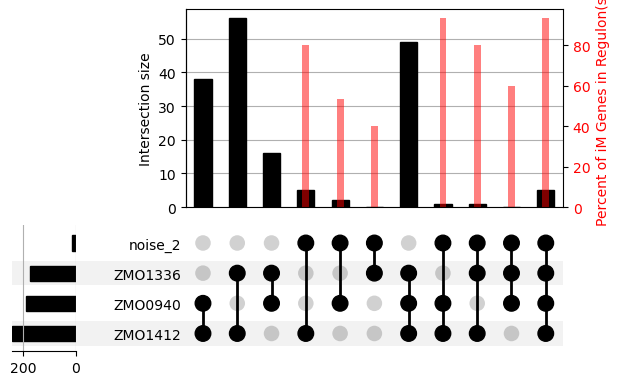

In [141]:
# selection
iM = 'noise_2'
max_regs = 3

if True:
    # generate data for upset plot
    sets = {}
    reg_to_size = {}
    for reg in temp[temp['imodulon'] == iM].regulator:
        targets = set(df_trn[df_trn['regulator'] == reg].gene_id)
        reg_to_size.update({reg : len(targets)})
    for reg in [k for k, _ in sorted(reg_to_size.items(), key = lambda k : -k[1])]:
        targets = set(df_trn[df_trn['regulator'] == reg].gene_id)
        if len(sets) < max_regs:
            sets.update({reg : targets})
    sets.update({iM : set(ica_data.view_imodulon(iM).index)})
    plotting_data = from_contents(sets)
    plotting_data = plotting_data.sort_values(list(sets.keys())[::-1], ascending = False)

    # Plot UpSet
    if len(sets) < 5:
        min_subset_size = 0
    else:
        min_subset_size = 0
    upset = UpSet(plotting_data, include_empty_subsets=True, min_subset_size=min_subset_size,
                  subset_size='count', max_degree = 5,
                  min_degree=2, sort_by='degree', sort_categories_by='input')
    upset.plot()
    
    # Get the current axis and create second y-axis
    current_ax = plt.gca()
    ax2 = current_ax.twinx()

    # here is the category order
    cat_groups = upset.intersections.index

    # For each intersection
    for i, combo in enumerate(cat_groups):
        if i < len(current_ax.patches):
            # Get the sets involved
            involved_sets = [name for name, included in zip(plotting_data.index.names, combo) if included]
            
            # get the iModulon
            iM_use = None
            for opt in involved_sets:
                if opt in temp.imodulon.values:
                    iM_use = opt
                else:
                    union_start = opt
            
            if iM_use:
                # Calculate union of non iM sets
                union = sets[union_start]
                for set_name in involved_sets:
                    if set_name == iM_use: continue
                    union = union | sets[set_name]

                # find iM genes that are in union
                iM_genes_contained = sets[iM_use] & union
                overlap_percent = (len(iM_genes_contained) / len(sets[iM_use])) * 100
            else:
                overlap_percent = 0

            # old way - calculates total intersection between all groups
            if False:
                # Calculate intersection
                intersection = sets[involved_sets[0]]
                for set_name in involved_sets[1:]:
                    intersection = intersection & sets[set_name]

                # Calculate union
                union = sets[involved_sets[0]]
                for set_name in involved_sets[1:]:
                    union = union | sets[set_name]

                # Calculate overlap percentage
                iM = None
                for opt in involved_sets:
                    if opt in temp.imodulon.values:
                        iM = opt
                if iM:
                    overlap_percent = (len(intersection) / len(sets[iM])) * 100
                else:
                    overlap_percent = 0

            # Debug print
            #print(f"Bar {i}: {involved_sets} = {len(intersection)} ... {overlap_percent:.2f}%")

            # Plot percentage bar
            x_pos = current_ax.patches[i].get_x() + current_ax.patches[i].get_width()/2
            ax2.bar(x_pos, overlap_percent, width=0.2, color='red', alpha=0.5)

    # Configure second y-axis (optional)
    ax2.set_ylabel('Percent of iM Genes in Regulon(s)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.savefig(base_dir+'/figures/overlaping_sets.pdf', transparent = True)
    plt.show()

You can also search for AND/OR combinations of regulators using the `max_regs` argument.

Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table.

In [104]:
# First search for regulator enrichments with 2 regulators
ica_data.compute_trn_enrichment(max_regs=2,save=True)

# Next, search for regulator enrichments with just one regulator. This will supercede the 2 regulator enrichments.
ica_data.compute_trn_enrichment(max_regs=1,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,noise_2,ZMO1412,4.579289e-09,6.868934e-08,0.8,0.049180,0.092664,12.0,244.0,15.0,1.0
1,noise_2,ZMO1206,9.702752e-07,7.277064e-06,0.6,0.052326,0.096257,9.0,172.0,15.0,1.0


The list of regulatory iModulons are shown below

In [105]:
regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
print(len(ica_data.imodulon_table),'Total iModulons')
print(len(regulatory_imodulons),'Regulatory iModulons')
regulatory_imodulons

63 Total iModulons
5 Regulatory iModulons


,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,category,percent_anaero_essential,single_gene,percent_aero_essential,explained_variance
SG_5,ZMO0203+ZMO1235,0.000000e+00,0.000000e+00,1.0,1.00000,1.000000,1.0,1.0,1.0,2.0,single gene,0.000000,True,0.000000,0.004183
SG_9,ZMO0050+ZMO0244,0.000000e+00,0.000000e+00,1.0,1.00000,1.000000,1.0,1.0,1.0,2.0,single gene,0.000000,True,0.000000,0.000950
SG_12,ZMO0199+ZMO0471,0.000000e+00,0.000000e+00,1.0,1.00000,1.000000,1.0,1.0,1.0,2.0,single gene,0.000000,True,0.000000,0.002239
noise_2,ZMO1412,4.579289e-09,6.868934e-08,0.8,0.04918,0.092664,12.0,244.0,15.0,1.0,noise,0.066667,NaN,0.066667,0.002123
SG_16,ZMO0100+ZMO0478,0.000000e+00,0.000000e+00,1.0,1.00000,1.000000,1.0,1.0,1.0,2.0,single gene,0.000000,True,0.000000,0.000684


You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

If two iModulons have the same regulator (e.g. 'Reg'), they will be named 'Reg-1' and 'Reg-2'

In [106]:
#ica_data.rename_imodulons(regulatory_imodulons.regulator.to_dict())
#ica_data.imodulon_table.head()

In [107]:
#regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]

# Functional iModulons

GO annotations and KEGG pathways/modules were generated in the 1_create_the_gene_table.ipynb notebook. Enrichments will be calculated in this notebook, and further curated in the 3_manual_iModulon_curation notebook.

## GO Enrichments

First load the Gene Ontology annotations

In [108]:
DF_GO = pd.read_csv(path.join(external_data,'GO_annotations_curated.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_name,gene_ontology
335,ZMO1_ZMO2031,rpmF,structural constituent of ribosome
339,ZMO1_ZMO1639,murJ,plasma membrane
1220,ZMO1_ZMO2004,rpsS,ribosomal small subunit assembly
1221,ZMO1_ZMO2004,rpsS,structural constituent of ribosome
1222,ZMO1_ZMO2004,rpsS,cytosolic small ribosomal subunit


In [109]:
#DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [110]:
#DF_GO_enrich.head()

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [111]:
DF_KEGG = pd.read_csv(path.join(external_data,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
7,ZMO1_ZMO0005,KEGG_pathway,map00230
8,ZMO1_ZMO0005,KEGG_pathway,map00261
9,ZMO1_ZMO0005,KEGG_pathway,map00450
10,ZMO1_ZMO0005,KEGG_pathway,map00920
11,ZMO1_ZMO0005,KEGG_pathway,map01100


In [112]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [113]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
# let's add links to view highlighted KEGG maps
links = []
for index, row in DF_pathway_enrich.iterrows():
    EC_nums = ica_data.view_imodulon(row['imodulon']).EC_number
    EC_num_opts = set()
    for val in EC_nums.values:
        if val == '': continue
        if str(val) == 'nan': continue
        for val2 in val.split(','):
            EC_num_opts.add(val2)
    url = 'https://www.kegg.jp/kegg-bin/show_pathway?map='+row['kegg_id']+'&multi_query='+'%0A'.join(EC_num_opts)
    links.append(url)
DF_pathway_enrich['KEGG_highlight_link'] = links
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [114]:
pd.set_option('display.max_colwidth', None)
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link
0,nitrogen_fixation,map00625,3.725372e-06,6.891938e-04,0.250000,0.500000,0.333333,3.0,6.0,12.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00625&multi_query=1.3.7.7%0A2.8.1.7%0A1.18.6.1
1,nitrogen_fixation,map00910,2.203800e-05,2.038515e-03,0.250000,0.300000,0.272727,3.0,10.0,12.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00910&multi_query=1.3.7.7%0A2.8.1.7%0A1.18.6.1
2,motility,map02040,1.939576e-28,3.588215e-26,0.842105,0.516129,0.640000,16.0,31.0,19.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map02040&multi_query=3.6.3.14
3,tetR_family_KO_2,map01501,5.629950e-07,1.041541e-04,0.750000,0.272727,0.400000,3.0,11.0,4.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map01501&multi_query=
4,tetR_family_KO_2,map01503,1.961625e-05,1.814504e-03,0.500000,0.500000,0.500000,2.0,4.0,4.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map01503&multi_query=


In [115]:
DF_pathway_enrich[DF_pathway_enrich['kegg_id'] == 'map00030']

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link
27,glycolysis_and_ATP_synthase,map00030,0.000045,0.001035,0.142857,0.266667,0.186047,4.0,15.0,28.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00030&multi_query=2.5.1.3%0A2.2.1.1%0A4.1.1.12%0A2.7.2.3%0A2.7.1.2%0A2.6.99.2%0A5.4.2.11%0A4.1.1.1%0A2.7.1.40%0A1.1.99.28%0A4.1.2.14%0A5.2.1.8%0A3.1.1.31%0A1.1.1.1%0A3.6.3.14%0A1.2.1.12%0A4.2.1.11%0A4.2.1.12%0A4.1.3.42


In [116]:
DF_pathway_enrich[DF_pathway_enrich['imodulon'] == 'ETC_and_MEP']

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link


In [117]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,nitrogen_fixation,M00175,1.882557e-07,3.219173e-05,0.25,1.0,0.400000,3.0,3.0,12.0
1,tetR_family_KO_2,M00647,3.422832e-09,2.926521e-07,0.75,1.0,0.857143,3.0,3.0,4.0
2,tetR_family_KO_2,M00718,3.422832e-09,2.926521e-07,0.75,1.0,0.857143,3.0,3.0,4.0
3,tetR_family_KO_2,M00699,3.273939e-06,1.866145e-04,0.50,1.0,0.666667,2.0,2.0,4.0
4,tetR_family_KO_2,M00642,2.088773e-03,4.464752e-02,0.25,1.0,0.400000,1.0,1.0,4.0


### Convert KEGG IDs to human-readable names

In [118]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    if '-' not in key:
        text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    if '-' not in key:
        text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [119]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link,pathway_name
0,nitrogen_fixation,map00625,3.725372e-06,6.891938e-04,0.250000,0.500000,0.333333,3.0,6.0,12.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00625&multi_query=1.3.7.7%0A2.8.1.7%0A1.18.6.1,Chloroalkane and chloroalkene degradation
1,nitrogen_fixation,map00910,2.203800e-05,2.038515e-03,0.250000,0.300000,0.272727,3.0,10.0,12.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00910&multi_query=1.3.7.7%0A2.8.1.7%0A1.18.6.1,Nitrogen metabolism
2,motility,map02040,1.939576e-28,3.588215e-26,0.842105,0.516129,0.640000,16.0,31.0,19.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map02040&multi_query=3.6.3.14,Flagellar assembly
3,tetR_family_KO_2,map01501,5.629950e-07,1.041541e-04,0.750000,0.272727,0.400000,3.0,11.0,4.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map01501&multi_query=,beta-Lactam resistance
4,tetR_family_KO_2,map01503,1.961625e-05,1.814504e-03,0.500000,0.500000,0.500000,2.0,4.0,4.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map01503&multi_query=,Cationic antimicrobial peptide (CAMP) resistance


In [120]:
pd.set_option('display.max_colwidth', 1000)
DF_pathway_enrich[DF_pathway_enrich['kegg_id'] == 'map00010']

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,KEGG_highlight_link,pathway_name
21,glycolysis_and_ATP_synthase,map00010,4.793128e-11,3.065611e-09,0.285714,0.421053,0.340426,8.0,19.0,28.0,https://www.kegg.jp/kegg-bin/show_pathway?map=map00010&multi_query=2.5.1.3%0A2.2.1.1%0A4.1.1.12%0A2.7.2.3%0A2.7.1.2%0A2.6.99.2%0A5.4.2.11%0A4.1.1.1%0A2.7.1.40%0A1.1.99.28%0A4.1.2.14%0A5.2.1.8%0A3.1.1.31%0A1.1.1.1%0A3.6.3.14%0A1.2.1.12%0A4.2.1.11%0A4.2.1.12%0A4.1.3.42,Glycolysis / Gluconeogenesis


In [121]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,nitrogen_fixation,M00175,1.882557e-07,3.219173e-05,0.25,1.0,0.400000,3.0,3.0,12.0,"Nitrogen fixation, nitrogen => ammonia"
1,tetR_family_KO_2,M00647,3.422832e-09,2.926521e-07,0.75,1.0,0.857143,3.0,3.0,4.0,None
2,tetR_family_KO_2,M00718,3.422832e-09,2.926521e-07,0.75,1.0,0.857143,3.0,3.0,4.0,"Multidrug resistance, efflux pump MexAB-OprM"
3,tetR_family_KO_2,M00699,3.273939e-06,1.866145e-04,0.50,1.0,0.666667,2.0,2.0,4.0,None
4,tetR_family_KO_2,M00642,2.088773e-03,4.464752e-02,0.25,1.0,0.400000,1.0,1.0,4.0,"Multidrug resistance, efflux pump MexJK-OprM"


## Save files

In [122]:
#DF_GO_enrich['source'] = 'GO'
# DF_pathway_enrich['source'] = 'KEGG pathways'
# DF_module_enrich['source'] = 'KEGG modules'
# DF_subti_enrich['source'] = 'SubtiWiki'

#DF_GO_enrich.rename({'gene_ontology':'annotation'},axis=1, inplace=True)
# DF_pathway_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
# DF_module_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
# DF_subti_enrich.rename({'value':'annotation'},axis=1, inplace=True)

#DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich, DF_subti_enrich])
#DF_enrichments.to_csv(path.join(data_dir,'functional_enrichments.csv'))

# Check for single gene iModulons

Some iModulons are dominated by a single, high-coefficient gene. These iModulons may result from:
1. Overdecomposition of the dataset to identify noisy genes
1. Artificial knock-out of single genes
1. Regulons with only one target gene

No matter what causes these iModulons, it is important to be aware of them. The find_single_gene_imodulons function identifies iModulons that are likely dominated by a single gene.

The iModulons identified by ``find_single_gene_imodulons`` may contain more than one gene, since a threshold-agnostic method is used to identify these iModulons.

In [123]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)
len(sg_imods)

23

In [124]:
for i,mod in enumerate(sg_imods):
    pass#ica_data.rename_imodulons({mod:'SG_'+str(i+1)})

In [125]:
ica_data.imodulon_table[ica_data.imodulon_table.single_gene == True]

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,category,percent_anaero_essential,single_gene,percent_aero_essential,explained_variance
SG_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,single gene,0.000000,True,0.000000,0.001166
SG_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,single gene,0.000000,True,0.000000,0.005724
SG_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,single gene,0.000000,True,0.000000,0.002829
SG_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,single gene,1.000000,True,1.000000,0.002410
unknown_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,uncharacterized,0.000000,True,0.000000,0.001178
SG_5,ZMO0203+ZMO1235,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,single gene,0.000000,True,0.000000,0.004183
membrane_cobalmin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,transport,0.075000,True,0.075000,0.007714
SG_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,single gene,0.000000,True,0.000000,0.004541
SG_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,single gene,0.000000,True,0.000000,0.001358
SG_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,single gene,0.000000,True,0.000000,0.001834


In [126]:
ica_data.view_imodulon('SG_1')

,gene_weight,gene_name,accession,start,end,strand,gene_product,COG,regulator,uniprot,...,aero_glucose_model_growth_perc_change,FIMO_regulators,LDI_early_glucose_fold_change,LDI_late_glucose_fold_change,LDI_early_xylose_fold_change,LDI_late_xylose_fold_change,no_LDI_early_glucose_fold_change,no_LDI_late_glucose_fold_change,no_LDI_early_xylose_fold_change,no_LDI_late_xylose_fold_change
ZMO1_ZMO2070,0.637664,ZMO1_ZMO2070,CP023715.1,1468858.0,1468941.0,+,hypothetical protein,No COG annotation,ZMO1697,NaN,...,NaN,['CosR_Campylobacter_jejuni'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# add on chromosome/plasmid location

In [127]:
f = open('../Zymomonas_mobilis/ZM4_files/genome.gff3', 'r')
lines = f.readlines()
f.close()
gene_to_reg = {}
for line in lines:
    if '##sequence-region' in line:
        seq_region = line.split(' ')[1]
    if 'ID=gene-' in line:
        gene = line.split('ID=gene-')[1].split(';')[0]
        gene_to_reg.update({gene : seq_region})
        
new_col = [gene_to_reg[index] for index in ica_data.gene_table.index]
ica_data.gene_table['chromosome_id'] = new_col

# what iModulons are "most essential"?

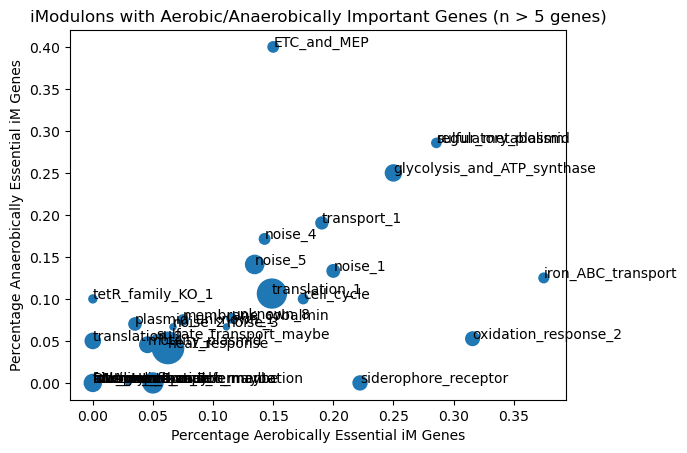

In [128]:
aero = []
anaero = []
min_size = 10
max_size = 500
for iM in ica_data.imodulon_table.index:
    df = ica_data.view_imodulon(iM)
    total = len(df)
    if 0 not in df['aerobic_essential'].value_counts():
        aerobic_ess = 1
    else:
        aerobic_ess = (total - df['aerobic_essential'].value_counts()[0]) / total
    if 0 not in df['anaerobic_essential'].value_counts():
        anaerobic_ess = 1
    else:
        anaerobic_ess = (total - df['anaerobic_essential'].value_counts()[0]) / total
    aero.append(aerobic_ess)
    anaero.append(anaerobic_ess)
ica_data.imodulon_table['percent_anaero_essential'] = anaero
ica_data.imodulon_table['percent_aero_essential'] = aero

df = ica_data.imodulon_table
df = df[df['imodulon_size'] > 5]
df.sort_values(by = 'percent_anaero_essential', ascending = False)[['category', 'explained_variance', 'imodulon_size', 'percent_aero_essential', 'percent_anaero_essential']]
x = df['percent_aero_essential']
y = df['percent_anaero_essential']

min_exp_var = min(df['explained_variance'])
max_exp_var = max(df['explained_variance'])
sizes = (df['explained_variance'] - min_exp_var) / (max_exp_var - min_exp_var)
sizes = (sizes * max_size) + min_size

plt.scatter(x, y, s = sizes)
for i, txt in enumerate(df.index):
    plt.annotate(txt, (x[i], y[i]))
plt.xlabel('Percentage Aerobically Essential iM Genes')
plt.ylabel('Percentage Anaerobically Essential iM Genes')
plt.title('iModulons with Aerobic/Anaerobically Important Genes (n > 5 genes)')
plt.savefig('../figures/aerobic_essential_anaerobic_essential_iM_scatter.pdf', transparent = True)
plt.show()

# add iModulons to gene_info

In [129]:
iMs = []
gene_to_iMs = {}
for iM in ica_data.imodulon_table.index:
    df = ica_data.view_imodulon(iM)
    for gene in df.index:
        if gene not in gene_to_iMs:
            gene_to_iMs.update({gene : []})
        gene_to_iMs[gene].append(iM)
for gene in ica_data.gene_table.index:
    if gene not in gene_to_iMs:
        iMs.append('')
    else:
        val = gene_to_iMs[gene]
        val.sort()
        iMs.append(str(val))
ica_data.gene_table['iMs'] = iMs

# Save iModulon object

In [149]:
from pymodulon.util import explained_variance
from pymodulon.io import *

In [150]:
# Add iModulon sizes and explained variance
for im in ica_data.imodulon_names:
    ica_data.imodulon_table.loc[im,'imodulon_size'] = len(ica_data.view_imodulon(im))
    ica_data.imodulon_table.loc[im,'explained_variance'] = explained_variance(ica_data,imodulons=im)

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [151]:
save_to_json(ica_data, path.join('..','data','processed_data','ZM4_ica.json.gz'))

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [152]:
ica_data.imodulon_table.to_csv(path.join('..','data','processed_data','imodulon_table_raw.csv'))

# what are iModulons not capturing?

In [180]:
M = ica_data.M
A = ica_data.A
rec_X = M.dot(A).T
gene_to_corr = {}
for gene in rec_X.columns:
    gene_to_corr.update({gene : np.corrcoef(rec_X[gene], ica_data.X.T[gene])[0,1]})
worst_genes = [k for k, _ in sorted(gene_to_corr.items(), key = lambda k : k[1])]
gene_info = ica_data.gene_table.copy()
corr_vals = []
for index in gene_info.index:
    corr_vals.append(gene_to_corr[index])
gene_info['corr_rec'] = corr_vals
gene_info['mean_exp'] = abs(ica_data.X.loc[gene_info.index]).mean(axis = 1)
bad_genes = gene_info[gene_info['corr_rec'] < 0.6]
good_genes = gene_info[gene_info['corr_rec'] >= 0.6]

# generating order for figures later
COGS = set(ica_data.gene_table.COG)
colors = plt.get_cmap('tab20')(range(len(COGS)))
COG_to_color = dict(zip(COGS, colors))
accs = set(ica_data.gene_table.accession)
colors = plt.get_cmap('tab20')(range(len(accs)))
acc_to_color = dict(zip(accs, colors))

In [154]:
a = bad_genes.sort_values(by = 'corr_rec').value_counts('COG', normalize = True)
a

COG
Function unknown                                                     0.162745
No COG annotation                                                    0.143137
Amino acid transport and metabolism                                  0.086275
Cell wall/membrane/envelope biogenesis                               0.066667
Transcription                                                        0.064706
Translation, ribosomal structure and biogenesis                      0.056863
Coenzyme transport and metabolism                                    0.050980
Replication, recombination and repair                                0.050980
Signal transduction mechanisms                                       0.037255
Lipid transport and metabolism                                       0.037255
Inorganic ion transport and metabolism                               0.037255
Carbohydrate transport and metabolism                                0.031373
Cell cycle control, cell division, chromosome partitioning  

In [155]:
b = good_genes.value_counts('COG', normalize = True)
b

COG
Function unknown                                                     0.178648
No COG annotation                                                    0.112456
Translation, ribosomal structure and biogenesis                      0.089680
Amino acid transport and metabolism                                  0.088256
Energy production and conversion                                     0.064057
Cell wall/membrane/envelope biogenesis                               0.059786
Transcription                                                        0.049110
Replication, recombination and repair                                0.048399
Nucleotide transport and metabolism                                  0.040569
Inorganic ion transport and metabolism                               0.039858
Coenzyme transport and metabolism                                    0.039858
Post-translational modification, protein turnover, and chaperones    0.039146
Carbohydrate transport and metabolism                       

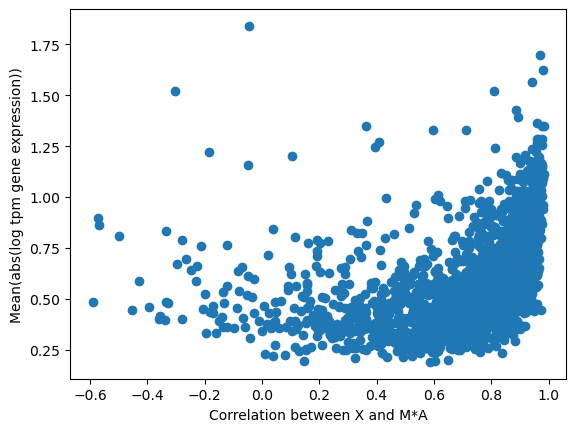

In [156]:
plt.scatter(gene_info['corr_rec'], gene_info['mean_exp'])
plt.xlabel('Correlation between X and M*A')
plt.ylabel('Mean(abs(log tpm gene expression))')
plt.savefig('../figures/recreated_expression.pdf', transparent = True)
plt.show()

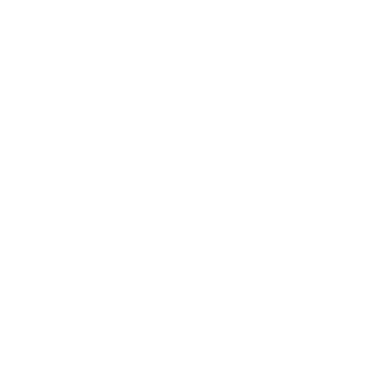

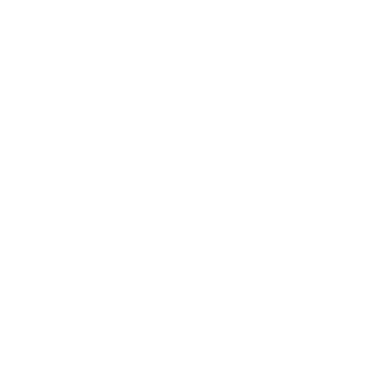

In [185]:
# pie charts of genes not captured
info = gene_info[gene_info['mean_exp'] < 0.1].value_counts('accession')
colors = [acc_to_color[ind] for ind in info.index]
plt.pie(x = info.values, labels = info.index, colors = colors)
plt.savefig('../figures/low_expr_chromes.pdf', transparent = True)
plt.show()

info = gene_info[gene_info['mean_exp'] < 0.1].value_counts('COG')
colors = [COG_to_color[ind] for ind in info.index]
plt.pie(x = info.values, labels = info.index, colors = colors)
plt.savefig('../figures/low_expr_COGS.pdf', transparent = True)
plt.show()

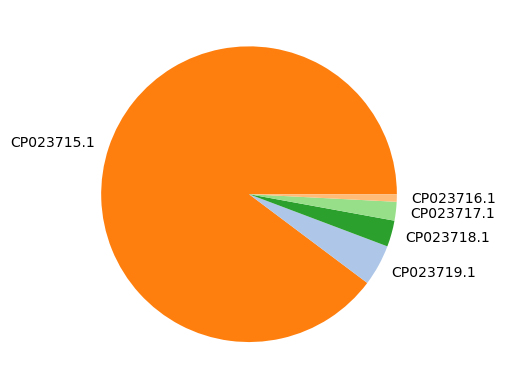

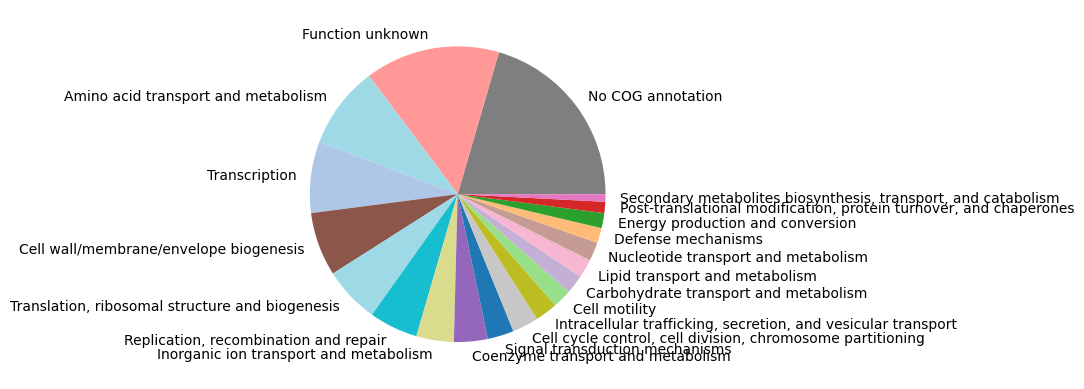

In [186]:
# pie charts of genes not recreated
info = gene_info[[c1 and c2 for c1, c2 in zip(gene_info['corr_rec'] < 0.4, gene_info['mean_exp'] > 0.1)]].value_counts('accession')
colors = [acc_to_color[ind] for ind in info.index]
plt.pie(x = info.values, labels = info.index, colors = colors)
plt.savefig('../figures/bad_corr_chromes.pdf', transparent = True)
plt.show()

info = gene_info[[c1 and c2 for c1, c2 in zip(gene_info['corr_rec'] < 0.4, gene_info['mean_exp'] > 0.1)]].value_counts('COG')
colors = [COG_to_color[ind] for ind in info.index]
plt.pie(x = info.values, labels = info.index, colors = colors)
plt.savefig('../figures/bad_corr_COGS.pdf', transparent = True)
plt.show()

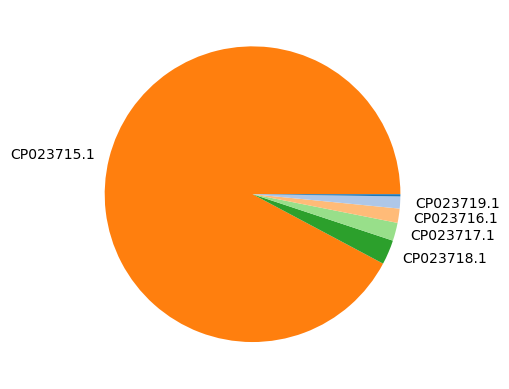

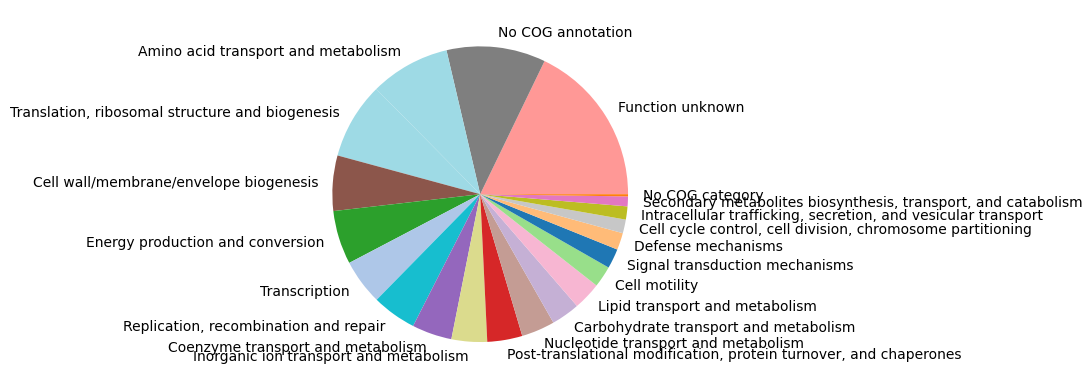

In [188]:
# pie charts of genes well recreated
info = gene_info[[c1 and c2 for c1, c2 in zip(gene_info['corr_rec'] > 0.4, gene_info['mean_exp'] > 0.1)]].value_counts('accession')
colors = [acc_to_color[ind] for ind in info.index]
plt.pie(x = info.values, labels = info.index, colors = colors)
plt.savefig('../figures/good_corr_chromes.pdf', transparent = True)
plt.show()

info = gene_info[[c1 and c2 for c1, c2 in zip(gene_info['corr_rec'] > 0.4, gene_info['mean_exp'] > 0.1)]].value_counts('COG')
colors = [COG_to_color[ind] for ind in info.index]
plt.pie(x = info.values, labels = info.index, colors = colors)
plt.savefig('../figures/good_corr_COGS.pdf', transparent = True)
plt.show()

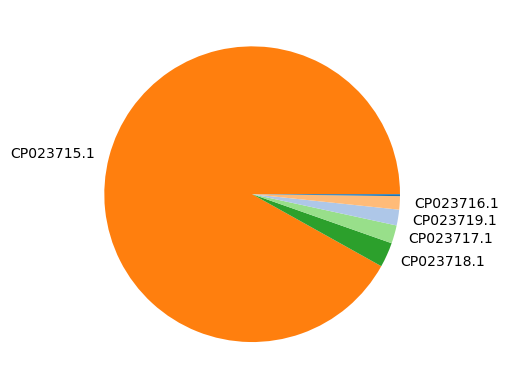

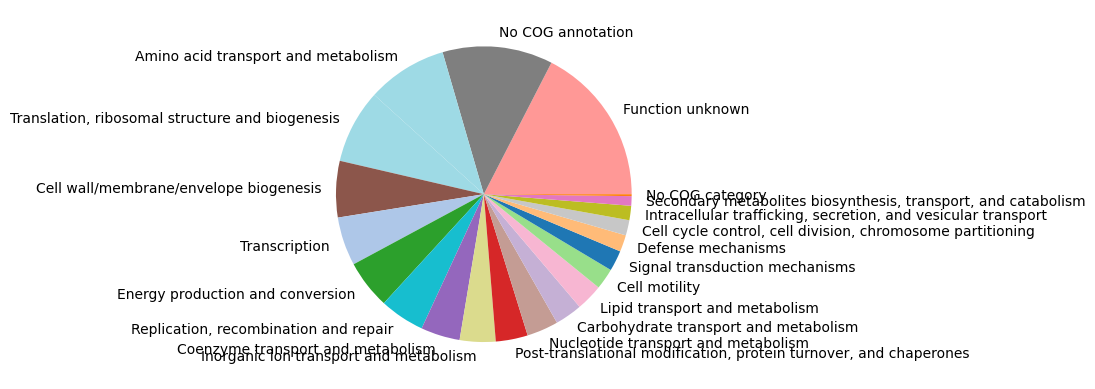

In [187]:
# pie chart of all genes
info = gene_info.value_counts('accession')
colors = [acc_to_color[ind] for ind in info.index]
plt.pie(x = info.values, labels = info.index, colors = colors)
plt.savefig('../figures/all_chromes.pdf', transparent = True)
plt.show()

info = gene_info.value_counts('COG')
colors = [COG_to_color[ind] for ind in info.index]
plt.pie(x = info.values, labels = info.index, colors = colors)
plt.savefig('../figures/all_COGS.pdf', transparent = True)
plt.show()

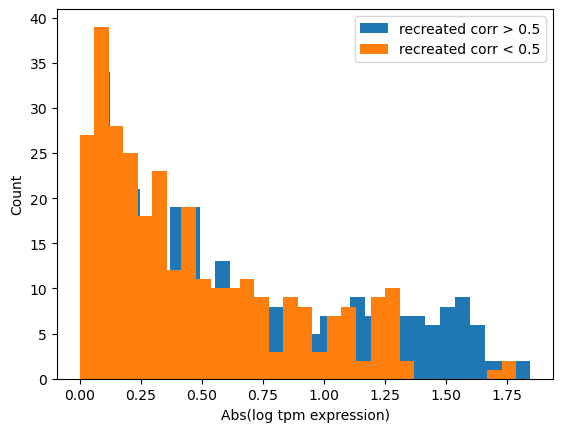

In [51]:
plt.figure()
plt.hist(abs(ica_data.X.loc[good_genes.index]).mean(), bins = 30, label = 'recreated corr > 0.5')
plt.hist(abs(ica_data.X.loc[bad_genes.index]).mean(), bins = 30, label = 'recreated corr < 0.5')
plt.xlabel('Abs(log tpm expression)')
plt.ylabel('Count')
plt.legend()
plt.show()

# let's create an output dataframe of iM information to add to the supplement

In [52]:
df = ica_data.imodulon_table.copy()
genes = []
mini_weights = []
for iM in df.index:
    genes_iM = ica_data.view_imodulon(iM).index.to_list()
    genes.append(genes_iM)
    temp = []
    for index, row in list(ica_data.view_imodulon(iM).sort_values(by = 'gene_weight', ascending = False).iterrows())[0:5]:
        temp.append(str(index))#+' = '+str(row['gene_weight']))
    mini_weights.append(', '.join(temp))
df['genes_contained'] = genes
df['top_5_gene_weights'] = mini_weights
cols_keep = [
    'explained_variance', 'category',
    'imodulon_size', 'genes_contained',
    'top_5_gene_weights',
]
df[cols_keep].sort_index(key = lambda x : x.str.lower()).to_csv('../data/iM_table_for_supplement.csv')

# playground